Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd

In [2]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/mnt/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/mnt/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

doga-MSISSD_khs_dir = /mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery
doga-MSISSD_data_path = /mnt/USB_HDD_1TB/Datasets
doga-MSISSD_experiment_path = /mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH


In [3]:
sys.path.insert(1, khs_dir)
import helperFuncs as funcH

/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/doga/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [4]:
EXPERIMENT_ID = 10
LOSS_TYPE='kl'
LOSS_REDUCTION='batchmean' #'sum','mean'
SIGMOID_ACT=True
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

In [5]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

In [6]:
#ap = argparse.ArgumentParser()
#ap.add_argument('-e', '--epochs', type=int, default=10, help='number of epochs to train our network for')
#ap.add_argument('-l', '--reg_param', type=float, default=0.001, help='regularization parameter `lambda`')
#ap.add_argument('-sc', '--add_sparse', type=str, default='yes', help='whether to add sparsity contraint or not')
#args = vars(ap.parse_args())
epochs = 200  # args['epochs']
reg_param = 0.001  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [7]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cuda:0


In [8]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

In [9]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.device = get_device()

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        bottleneck = F.relu(self.enc5(x))  
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

In [10]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [12]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    rho = 0.05
    bt = torch.mean(torch.sigmoid(bottleneck), 1)  # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(bt)).to(device)
    loss_ret_1 = torch.nn.functional.kl_div(bt, rho, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, sigmoidAct, reduction):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    else:
        bt = bottleneck    
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(bt, preds)    
    return loss_ret_1

In [13]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
    if print_info:
        print(loss_type,loss)
    return loss

In [14]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [15]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [16]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws05 :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws05 :: 
EXPERIMENT_ID:  10
LOSS_TYPE :  kl
LOSS_REDUCTION :  batchmean
SIGMOID_ACT :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param * sp_loss
*****
 Epoch 0 of 200
TrEpoch(000) - kl tensor(-0.1752, device='cuda:0', grad_fn=<AddBackward0>)
sp_loss: -0.17522896826267242

       acc     bmx  bmn      mse      spr      run
0  22.705  17.795  0.0  144.456 -346.926  144.109
ValEpoch(000) - 
      acc     bmx  bmn     run
0  25.57  18.598  0.0  17.209
*****
 Epoch 1 of 200
TrEpoch(001) - 
       acc     bmx  bmn    mse      spr     run
0  25.595  23.678  0.0  93.08 -352.948  92.727
ValEpoch(001) - 
      acc     bmx  bmn     run
0  25.86  23.324  0.0  14.275
*****
 Epoch 2 of 200
TrEpoch(002) - 
       acc     bmx  bmn     mse      spr     run
0  24.507  25.448  0.0  81.456 -353.642  81.103
ValEpoch(002) - 
      acc     bmx  bmn     run
0  28.65  24.659  0.0  13.011
*****
 Epoch 3 of 200
TrEpoch(003) - 
      acc     bmx  bmn     mse      spr     run
0  25.45  

TrEpoch(035) - 
      acc     bmx  bmn     mse      spr     run
0  23.71  27.776  0.0  41.114 -357.117  40.756
ValEpoch(035) - 
      acc     bmx  bmn    run
0  28.79  26.807  0.0  6.916
*****
 Epoch 36 of 200
TrEpoch(036) - kl tensor(-0.1902, device='cuda:0', grad_fn=<AddBackward0>)
sp_loss: -0.19021572172641754

      acc     bmx  bmn     mse      spr     run
0  18.47  28.038  0.0  40.803 -357.134  40.446
ValEpoch(036) - 
      acc     bmx  bmn   run
0  28.37  26.802  0.0  6.86
*****
 Epoch 37 of 200
TrEpoch(037) - 
      acc    bmx  bmn     mse      spr     run
0  17.75  27.99  0.0  40.433 -357.146  40.076
ValEpoch(037) - 
      acc     bmx  bmn    run
0  28.94  26.148  0.0  6.759
*****
 Epoch 38 of 200
TrEpoch(038) - 
       acc     bmx  bmn     mse      spr     run
0  21.502  27.548  0.0  40.056 -357.166  39.699
ValEpoch(038) - 
     acc     bmx  bmn    run
0  28.1  26.016  0.0  6.722
*****
 Epoch 39 of 200
TrEpoch(039) - 
       acc     bmx  bmn     mse     spr    run
0  18.655  


      acc     bmx  bmn    mse      spr     run
0  19.08  27.491  0.0  32.88 -358.757  32.521
ValEpoch(071) - 
      acc    bmx  bmn    run
0  23.33  26.44  0.0  5.569
*****
 Epoch 72 of 200
TrEpoch(072) - 
      acc     bmx  bmn     mse      spr     run
0  20.84  27.592  0.0  32.802 -358.772  32.443
ValEpoch(072) - 
      acc    bmx  bmn    run
0  23.64  26.34  0.0  5.568
*****
 Epoch 73 of 200
TrEpoch(073) - 
       acc     bmx  bmn     mse      spr     run
0  20.735  27.346  0.0  32.736 -358.777  32.377
ValEpoch(073) - 
     acc    bmx  bmn    run
0  19.3  26.27  0.0  5.552
*****
 Epoch 74 of 200
TrEpoch(074) - 

KeyboardInterrupt: 

In [17]:
print(result_df_tr_all)

       acc     bmx  bmn      mse      spr      run
0   22.705  17.795  0.0  144.456 -346.926  144.109
1   25.595  23.678  0.0   93.080 -352.948   92.727
2   24.507  25.448  0.0   81.456 -353.642   81.103
3   25.450  26.327  0.0   73.968 -354.035   73.614
4   24.833  28.018  0.0   67.884 -354.548   67.530
5   25.325  29.068  0.0   64.207 -355.046   63.851
6   24.768  29.269  0.0   61.723 -355.706   61.367
7   21.563  29.862  0.0   60.272 -356.093   59.915
8   25.942  29.833  0.0   59.016 -356.359   58.660
9   26.410  29.429  0.0   58.200 -356.479   57.843
10  27.893  29.286  0.0   56.808 -356.573   56.451
11  31.212  29.077  0.0   55.554 -356.599   55.197
12  27.753  28.647  0.0   54.946 -356.675   54.589
13  26.103  29.450  0.0   54.381 -356.745   54.025
14  29.795  29.501  0.0   53.593 -356.852   53.236
15  29.465  29.640  0.0   52.821 -356.891   52.465
16  29.438  29.800  0.0   51.130 -356.916   50.773
17  29.448  29.835  0.0   50.076 -356.932   49.719
18  29.312  29.354  0.0   49.48

In [18]:
print(result_df_va_all)

      acc     bmx  bmn     run
0   25.57  18.598  0.0  17.209
1   25.86  23.324  0.0  14.275
2   28.65  24.659  0.0  13.011
3   24.44  26.490  0.0  11.786
4   24.16  27.461  0.0  10.971
5   24.99  28.876  0.0  10.524
6   23.31  28.957  0.0  10.183
7   24.22  28.855  0.0   9.950
8   28.92  28.595  0.0   9.841
9   27.24  28.519  0.0   9.582
10  28.55  28.112  0.0   9.528
11  30.71  28.108  0.0   9.258
12  27.65  28.028  0.0   9.162
13  27.23  28.629  0.0   9.095
14  24.38  28.446  0.0   8.930
15  27.34  28.376  0.0   8.656
16  27.46  28.332  0.0   8.482
17  25.12  28.583  0.0   8.327
18  25.69  28.662  0.0   8.278
19  28.86  28.732  0.0   8.069
20  28.31  29.130  0.0   7.987
21  27.43  29.037  0.0   7.928
22  27.32  29.108  0.0   7.860
23  27.14  29.040  0.0   7.767
24  25.98  29.286  0.0   7.728
25  28.12  28.618  0.0   7.577
26  29.34  28.531  0.0   7.454
27  27.45  28.400  0.0   7.413
28  28.96  28.175  0.0   7.377
29  27.27  28.043  0.0   7.318
30  28.15  27.524  0.0   7.263
31  26.9

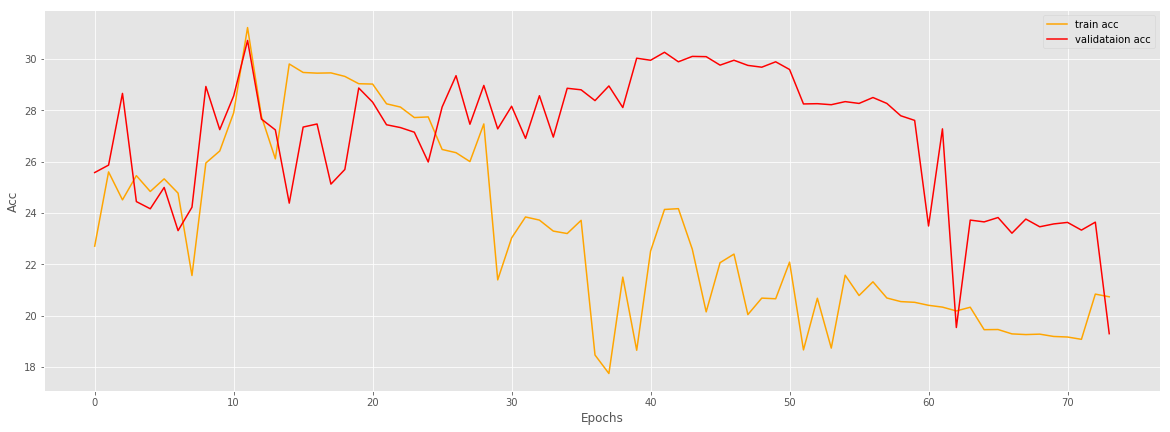

Max tr acc =  31.211666666666666
Max va acc =  30.71


In [22]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

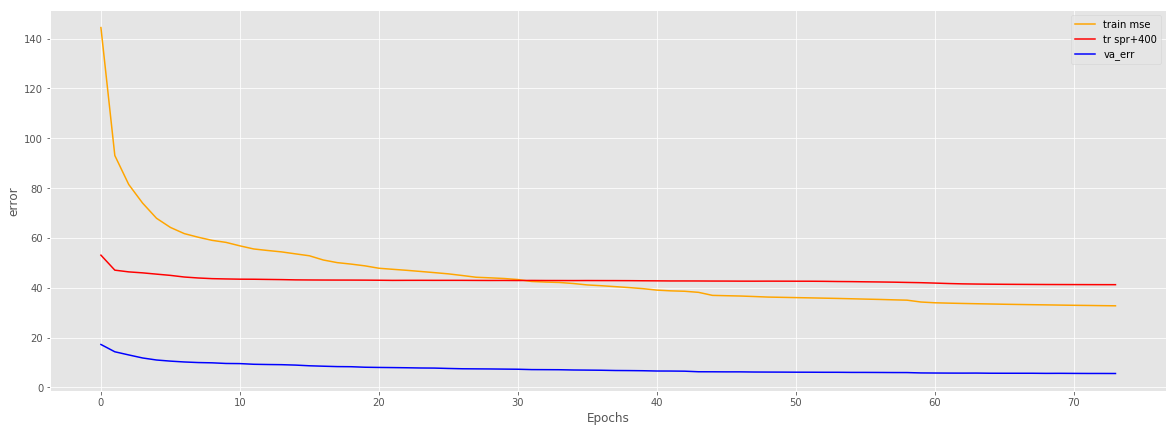

In [21]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr_50 = 400+result_df_tr_all.values[:,4].squeeze()
va_err = result_df_va_all.values[:,-1].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_mse, color='orange', label='train mse')
plt.plot(tr_spr_50, color='red', label='tr spr+400')
plt.plot(va_err, color='blue', label='va_err')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()